# 1 Get the data

In [1]:
# import the libraries to use
import pandas as pd
import seaborn as sns

sns.set_theme()

In [2]:
from src.utils import load_data, ReadCsvParams, SaveCsvParams

file_path = '../data/raw/url_spam.csv'
url = 'https://raw.githubusercontent.com/4GeeksAcademy/NLP-project-tutorial/main/url_spam.csv'
read_csv_params: ReadCsvParams = {'delimiter': ','}
save_csv_params: SaveCsvParams = {'sep': ','}

df: pd.DataFrame = load_data(
    file_path=file_path, url=url, read_csv_params=read_csv_params, save_csv_params=save_csv_params
)

Loading data from file: ../data/raw/url_spam.csv


In [3]:
# see the data
df.head()

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,True
1,https://www.hvper.com/,True
2,https://briefingday.com/m/v4n3i4f3,True
3,https://briefingday.com/n/20200618/m#commentform,False
4,https://briefingday.com/fan,True


In [4]:
# see the info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2999 entries, 0 to 2998
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   url      2999 non-null   object
 1   is_spam  2999 non-null   bool  
dtypes: bool(1), object(1)
memory usage: 26.5+ KB


## Verify the duplicates

In [5]:
duplicates = df.duplicated()
df[duplicates].sort_values(by='url', ascending=False)

,url,is_spam
2995,https://www.youtube.com/watch,True
2928,https://www.youtube.com/user/voxdotcom,True
1211,https://www.youtube.com/user/voxdotcom,True
1968,https://www.youtube.com/user/voxdotcom,True
2248,https://www.youtube.com/user/voxdotcom,True
...,...,...
2091,http://gettheelevator.com/editorial,True
2600,http://gettheelevator.com/editorial,True
1536,http://gettheelevator.com/,True
2090,http://gettheelevator.com/,True


In [6]:
duplicate_count = duplicates.sum()
print(f"Total duplicate rows: {duplicate_count}")

Total duplicate rows: 630


Delete all the duplicates

In [7]:
df = df.drop_duplicates()
df = df.reset_index(inplace = False, drop = True)
df.shape

(2369, 2)

## See the distribution of the spam target variable

<Axes: xlabel='is_spam', ylabel='count'>

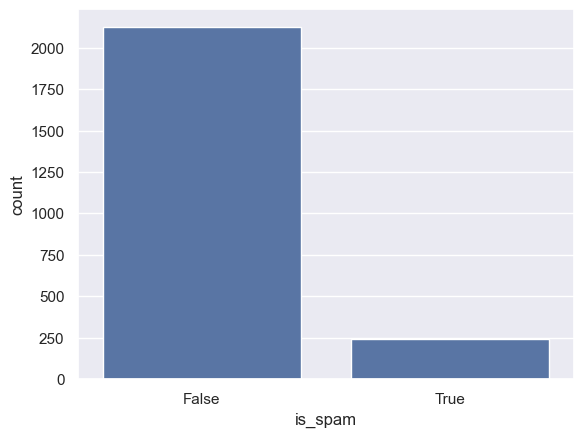

In [8]:
sns.countplot(df, x='is_spam')

We can see that the data is unbalanced, with a lot more non-spam than spam URLs. This is important to keep in mind when training the model, as it may affect the performance of it.

## Lets map the target value to be a binary integer value

In [9]:
df['is_spam'] = df['is_spam'].map({True: 1, False: 0})

<Axes: xlabel='is_spam', ylabel='count'>

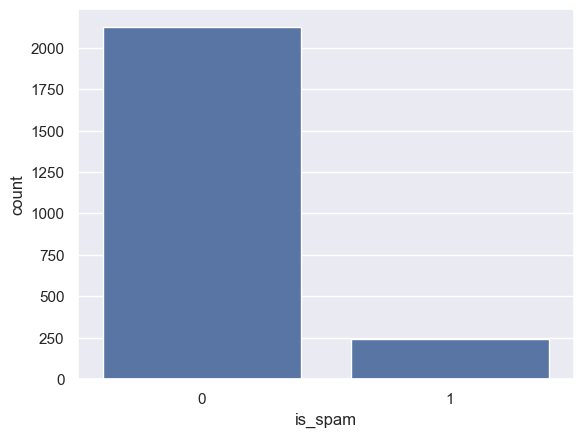

In [10]:
sns.countplot(df, x='is_spam')

Now we can proceed with the processing of the urls

# 2 Preprocessing of the urls

## In this step we are going to convert the data form urls to words.

In this step we are going to convert the data form urls to words.

In [11]:
import re


def preprocess_text(text) -> list[str] | str:
    """
    Preprocess the text by removing special characters and converting to lowercase.
    It deletes the "https://", "www", and ".com" parts of the url.

    Args:
        text (str): The input text to preprocess.

    Returns:
        list[str] | str: The preprocessed text.
    """

    # convert everything to lowercase
    text = text.lower()

    # remove the https://
    text = re.sub(r"https://|http://", "", text)

    # remove the www
    text = re.sub(r"www", "", text)

    # remove the com
    text = re.sub(r"com", "", text)

    # remove any character that is not a letter (a-z), a number or a white space with a white space
    text = re.sub(r"[^a-z\d ]", " ", text)

    # # remove white spaces
    # text = re.sub(r"\s+[a-zA-Z]\s+", " ", text)
    # text = re.sub(r"\^[a-zA-Z]\s+", " ", text)

    # multiple white spaces into one
    text = re.sub(r"\s+", " ", text)

    return text.split()

See the data to compare to the processed one

In [12]:
df.head(10)

,url,is_spam
0,https://briefingday.us8.list-manage.com/unsubs...,1
1,https://www.hvper.com/,1
2,https://briefingday.com/m/v4n3i4f3,1
3,https://briefingday.com/n/20200618/m#commentform,0
4,https://briefingday.com/fan,1
5,https://www.brookings.edu/interactives/reopeni...,0
6,https://www.reuters.com/investigates/special-r...,0
7,https://www.theatlantic.com/magazine/archive/2...,0
8,https://www.vox.com/2020/6/17/21294680/john-bo...,0
9,https://www.theguardian.com/travel/2020/jun/18...,0


Apply the preprocessing function to the urls

In [13]:
# create a new dataframe to process
preprocessed_df = df.copy()

# process the data
preprocessed_df['url'] = preprocessed_df['url'].apply(preprocess_text)
preprocessed_df.head(10)

,url,is_spam
0,"[briefingday, us8, list, manage, unsubscribe]",1
1,[hvper],1
2,"[briefingday, m, v4n3i4f3]",1
3,"[briefingday, n, 20200618, m, mentform]",0
4,"[briefingday, fan]",1
5,"[brookings, edu, interactives, reopening, amer...",0
6,"[reuters, investigates, special, report, healt...",0
7,"[theatlantic, magazine, archive, 2020, 07, sup...",0
8,"[vox, 2020, 6, 17, 21294680, john, bolton, boo...",0
9,"[theguardian, travel, 2020, jun, 18, end, of, ...",0


## Lemmatize the text

In [14]:
from nltk import download
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# download the lemmatizer
#download("wordnet")
word_net_lemmatizer = WordNetLemmatizer()

# get the stop words
#download("stopwords")
stop_words = stopwords.words("english")


def lemmatize_text(words, lemmatizer = word_net_lemmatizer) -> list[str]:
    """
    lemmatize the text by removing stop words and lemmatizing the words.

    Args:
        words (list[str]): The input text to lemmatize.
        lemmatizer (WordNetLemmatizer): The lemmatizer to use.

    Returns:
        list[str]: The lemmatized text.
    """

    # lemmatize the words
    tokens = [lemmatizer.lemmatize(word) for word in words]

    # delete the stop words
    tokens = [word for word in tokens if word not in stop_words]

    return tokens

In [15]:
preprocessed_df['url'] = preprocessed_df['url'].apply(lemmatize_text)
preprocessed_df.head(10)

,url,is_spam
0,"[briefingday, us8, list, manage, unsubscribe]",1
1,[hvper],1
2,"[briefingday, v4n3i4f3]",1
3,"[briefingday, n, 20200618, mentform]",0
4,"[briefingday, fan]",1
5,"[brookings, edu, interactives, reopening, amer...",0
6,"[reuters, investigates, special, report, healt...",0
7,"[theatlantic, magazine, archive, 2020, 07, sup...",0
8,"[vox, 2020, 6, 17, 21294680, john, bolton, boo...",0
9,"[theguardian, travel, 2020, jun, 18, end, tour...",0


## Lets visualize the data with a word cloud

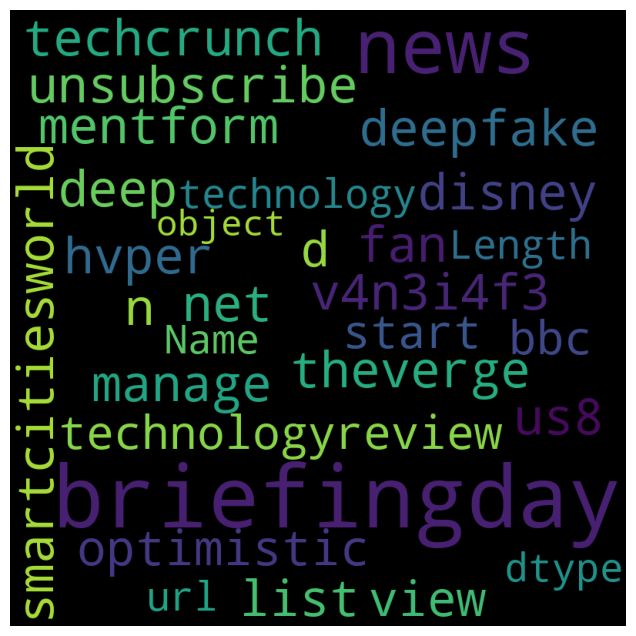

In [16]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud

# create the wordcloud
wordcloud = WordCloud(
    width = 800,
    height = 800,
    background_color = "black",
    max_words = 1000,
    min_font_size = 20,
    random_state = 42
).generate(str(preprocessed_df['url']))

fig = plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

We can see that there are no words that over power to much the others. The most common word is 'briefingday'.

# 3 Convert the data to numbers

In [17]:
from sklearn.feature_extraction.text import TfidfVectorizer

# add all the words to just a list
tokens_list = preprocessed_df['url']
tokens_list = [" ".join(tokens) for tokens in tokens_list]

# vectorize the data, here we are going to use the TfidfVectorizer
vectorizer = TfidfVectorizer(max_features = 5000, max_df = 0.8, min_df = 5)

# get the tokes and the target
X = vectorizer.fit_transform(tokens_list).toarray()
y = preprocessed_df['is_spam']

# 4 Split the data in train and test

In [18]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# 5 Create the model

In [19]:
from sklearn.svm import SVC

# create the model and fit it to the data
model = SVC(kernel = 'linear', random_state = 42)
model.fit(X_train, y_train)

SVC(kernel='linear', random_state=42)

Make the predictions

In [20]:
# predictions
y_pred = model.predict(X_test)

# 6 Evaluate the model

In [21]:
from sklearn.metrics import (accuracy_score, precision_score, recall_score,
                             f1_score, confusion_matrix, classification_report)

default_model_accuracy = accuracy_score(y_test, y_pred)
default_model_precision = precision_score(y_test, y_pred)
default_model_recall = recall_score(y_test, y_pred)
default_model_f1 = f1_score(y_test, y_pred)
default_model_report = classification_report(y_test, y_pred)

print(f'Accuracy: {default_model_accuracy}')
print(f'Precision: {default_model_precision}')
print(f'Recall: {default_model_recall}')
print(f'F1-Score: {default_model_f1}\n')
print(f'Classification Report:\n{default_model_report}')

Accuracy: 0.9620253164556962
Precision: 0.8888888888888888
Recall: 0.6153846153846154
F1-Score: 0.7272727272727273

Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.99      0.98       435
           1       0.89      0.62      0.73        39

    accuracy                           0.96       474
   macro avg       0.93      0.80      0.85       474
weighted avg       0.96      0.96      0.96       474



We can see that the model has a good performance with the negative label but with the positive label is not good, this is because of the unbalanced data.

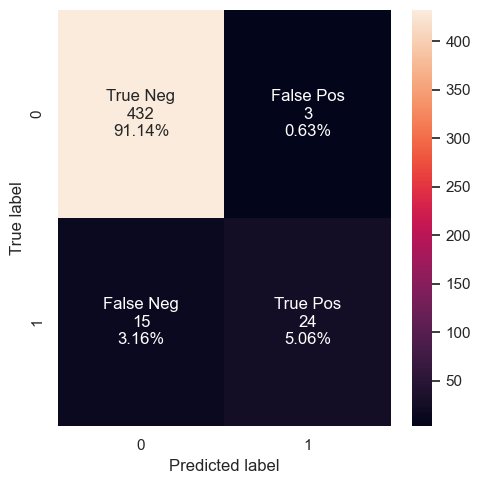

In [22]:
from src.draw_utils import draw_confusion_matrix

# draw the confusion matrix
default_model_confusion = confusion_matrix(y_test, y_pred)
draw_confusion_matrix(confusion=default_model_confusion)

We can see again that the performance with the true positive is not good, this means that the model is not going to be as good at detecting the span urls vs detecting the ones that are not spam.

# Optimize the model

In [23]:
from sklearn.svm import SVC

# create the model and fit it to the data
opt_model = SVC(random_state = 42)

Hyperparams to try

In [24]:
from sklearn.model_selection import GridSearchCV

# hyperparams to test, we have some for the linear kernel and some for the rbf kernel
hyperparams = [
    {'kernel': ['linear'], 'C': [0.001, 0.01, 0.1, 1, 10], 'class_weight': [None, 'balanced']},
    {'kernel': ['rbf'], 'C': [0.001, 0.01, 0.1, 1, 10], 'gamma': ['scale', 'auto'], 'class_weight': [None, 'balanced']}
]

# initialize the grid
grid = GridSearchCV(opt_model, hyperparams, scoring='roc_auc', cv=5, n_jobs=-1, verbose=1)

## Fit the model

In [25]:
grid.fit(X_train, y_train.values)

print(f"Best hyperparameters: {grid.best_params_}")

Fitting 5 folds for each of 30 candidates, totalling 150 fits
Best hyperparameters: {'C': 1, 'class_weight': 'balanced', 'kernel': 'linear'}


In [26]:
# get the best parameters and model
best_params = grid.best_params_
best_model: SVC = grid.best_estimator_

In [27]:
# predict the values
y_pred = best_model.predict(X_test)

## Metrics

In [28]:
opt_model_accuracy = accuracy_score(y_test, y_pred)
opt_model_precision = precision_score(y_test, y_pred)
opt_model_recall = recall_score(y_test, y_pred)
opt_model_f1 = f1_score(y_test, y_pred)
opt_model_report = classification_report(y_test, y_pred)

print(f'Accuracy: {opt_model_accuracy}')
print(f'Precision: {opt_model_precision}')
print(f'Recall: {opt_model_recall}')
print(f'F1-Score: {opt_model_f1}\n')
print(f'Classification Report:\n{opt_model_report}')

Accuracy: 0.9135021097046413
Precision: 0.484375
Recall: 0.7948717948717948
F1-Score: 0.6019417475728155

Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.92      0.95       435
           1       0.48      0.79      0.60        39

    accuracy                           0.91       474
   macro avg       0.73      0.86      0.78       474
weighted avg       0.94      0.91      0.92       474



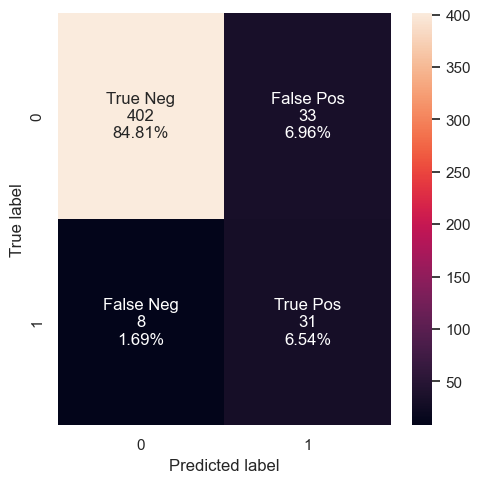

In [29]:
# draw the confusion matrix
default_model_confusion = confusion_matrix(y_test, y_pred)
draw_confusion_matrix(confusion=default_model_confusion)

We can see that this model is much better classifying the spam urls. This is much important than the classification of the no spam urls. So in this case we should choose this model.

# Save the model

In [30]:
from pickle import dump

model_dile_name = '../models/opt_model.sav'

# save the model
with open(model_dile_name, "wb") as file:
    dump(best_model, file)